# SVM on Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>



The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
from bs4 import BeautifulSoup
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [04:26<00:00, 1364.88it/s]


In [ ]:
#combining required columns
final['clean_text'] = preprocessed_reviews
final = final[['Time','clean_text','Score']]
#reseting index
final = final.reset_index(drop=True)

In [ ]:
#sampling 100k points 
final_100k = final.sample(100000)
#sorting 100kpoints based on time
final_100k['Time'] = pd.to_datetime(final_100k['Time'],unit='s')
final_100k = final_100k.sort_values('Time')
#reseting index
final_100k = final_100k.reset_index(drop=True)

In [ ]:
final_100k.head()

,Time,clean_text,Score
0,1999-12-06,twist rumplestiskin captured film starring mic...,1
1,2000-01-03,beetlejuice excellent funny movie keaton hilar...,1
2,2000-01-09,one movie movie collection filled comedy actio...,1
3,2000-01-24,bought apartment infested fruit flies hours tr...,1
4,2000-12-05,sick scads nasty toothpicks counter tinting ic...,1


In [ ]:
final_100k['Score'].value_counts()

1    84339
0    15661
Name: Score, dtype: int64

observation: We have clearly an imbalenced dataset

In [ ]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = final_100k['clean_text']
y = final_100k['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3)

# [4] Featurization


# Linear SVM

## Linear SVM in BOW

In [ ]:
#applying bow on x_train and x_test
vectorizer = CountVectorizer()
vectorizer.fit(X_tr)
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_tr)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_cv_bow is {}'.format(X_cv_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (49000, 42843)
shape of X_cv_bow is (21000, 42843)
shape of X_test_bow is (30000, 42843)


Model with best parameters :
 {'alpha': 0.001, 'penalty': 'l2'}


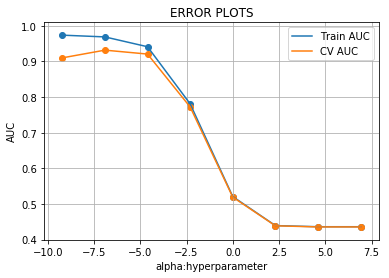

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3)
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc= model.cv_results_['mean_train_score'][1:17:2]
cv_auc = model.cv_results_['mean_test_score'] [1:17:2]
plt.plot(np.log(Alpha), train_auc, label='Train AUC')
plt.plot(np.log(Alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(Alpha), train_auc)
plt.scatter(np.log(Alpha), cv_auc)
plt.legend()
plt.grid(True)
plt.xlabel("alpha:hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

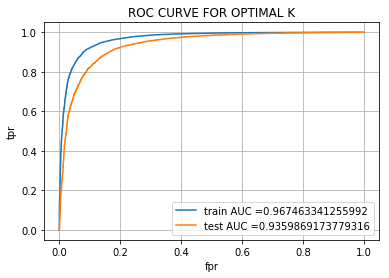

Area under train roc 0.967463341255992
Area under test roc 0.9359869173779316


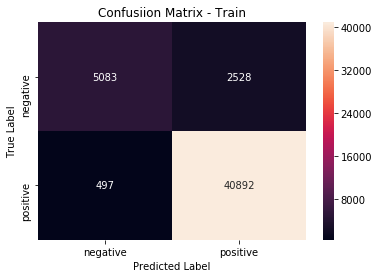

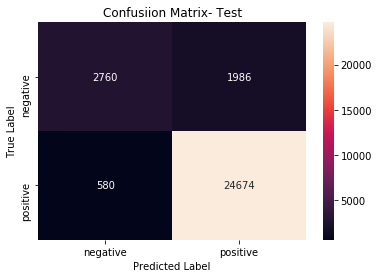

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
optimal_alpha = 0.001
optimal_penalty= 'l2'
svm_opt = SGDClassifier(alpha=optimal_alpha,penalty=optimal_penalty,loss='hinge') 
svm_opt.fit(X_train_bow,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_bow))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_bow))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
data_l1 = svm_opt.coef_.reshape(-1,1)
features = vectorizer.get_feature_names()
datafr_l1 = pd.DataFrame(data_l1,columns=['coef'],index=features)
#Top 10 negative features
negative = datafr_l1.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l1.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                     coef
worst          -1.068616
terrible       -0.852446
disappointing  -0.832053
awful          -0.766794
disappointment -0.766794
disappointed   -0.726007
return         -0.701534
horrible       -0.693377
threw          -0.656669
stale          -0.636275
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
                coef
delicious  0.644433
perfect    0.558780
excellent  0.550623
wonderful  0.546544
best       0.538387
awesome    0.501679
loves      0.493521
great      0.477207
highly     0.477207
amazing    0.469049


##  Linear SVM in TFIDF

In [ ]:
#applying tfidf on x_train and x_test
vectorizer = TfidfVectorizer()
vectorizer.fit(X_tr)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_tr)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

Model with best parameters :
 {'alpha': 0.0001, 'penalty': 'l2'}


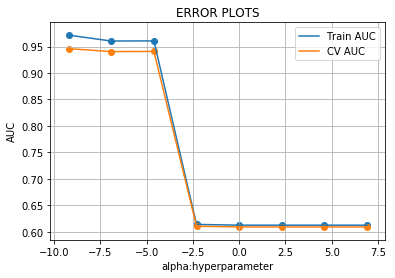

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3)
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc= model.cv_results_['mean_train_score'][1:17:2]
cv_auc = model.cv_results_['mean_test_score'] [1:17:2]
plt.plot(np.log(Alpha), train_auc, label='Train AUC')
plt.plot(np.log(Alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(Alpha), train_auc)
plt.scatter(np.log(Alpha), cv_auc)
plt.legend()
plt.grid(True)
plt.xlabel("alpha:hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

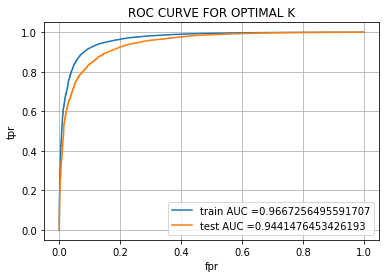

Area under train roc 0.9667256495591707
Area under test roc 0.9441476453426193


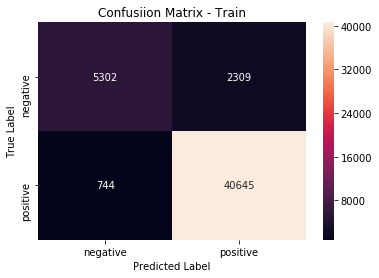

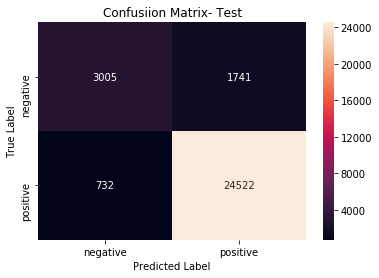

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
optimal_alpha = 0.0001
optimal_penalty= 'l2'
svm_opt = SGDClassifier(alpha=optimal_alpha,penalty=optimal_penalty,loss='hinge') 
svm_opt.fit(X_train_tfidf,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_tfidf))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_tfidf))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Top 10 features

In [ ]:
data_l1 = svm_opt.coef_.reshape(-1,1)
features = vectorizer.get_feature_names()
datafr_l1 = pd.DataFrame(data_l1,columns=['coef'],index=features)
#Top 10 negative features
negative = datafr_l1.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l1.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                     coef
worst          -3.882530
terrible       -3.205484
not            -3.068434
disappointed   -3.024886
return         -3.018544
horrible       -2.895836
awful          -2.885724
disappointment -2.834181
disappointing  -2.546954
threw          -2.451686
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
                coef
great      4.003276
delicious  2.995456
best       2.830766
good       2.587256
love       2.427530
perfect    2.318755
excellent  2.140048
loves      2.074616
wonderful  2.028561
nice       1.827708


## Linear SVM on AVG - Word2Vec

In [ ]:
# Train your own Word2Vec model using your own text corpus
preprocessed_reviews = X_tr.values
train_sentance=[]
for sentance in preprocessed_reviews:
    train_sentance.append(sentance.split())

want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(train_sentance,min_count=5,size=50, workers=4)
w2v_words_train = list(w2v_model_train.wv.vocab)

In [ ]:
# compute average word2vec for each review for train data.
preprocessed_reviews = X_tr.values
list_of_sentancetrain = []
for sentance in preprocessed_reviews:
    list_of_sentancetrain.append(sentance.split())


sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetrain): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

###########################################################
# compute average word2vec for each review for cv data.
preprocessed_reviews = X_cv.values
list_of_sentancecv = []
for sentance in preprocessed_reviews:
    list_of_sentancecv.append(sentance.split())

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancecv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

#################################################################

# compute average word2vec for each review for test data.
preprocessed_reviews = X_test.values
list_of_sentancetest = []
for sentance in preprocessed_reviews:
    list_of_sentancetest.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 49000/49000 [03:10<00:00, 257.74it/s]


49000
50


100%|██████████| 21000/21000 [01:23<00:00, 250.39it/s]


21000
50


100%|██████████| 30000/30000 [01:58<00:00, 253.53it/s]


30000
50


In [ ]:
X_train_avgw2v = sent_vectors_train
X_cv_avgw2v = sent_vectors_cv
X_test_avgw2v = sent_vectors_test

Model with best parameters :
 {'alpha': 0.01, 'penalty': 'l2'}


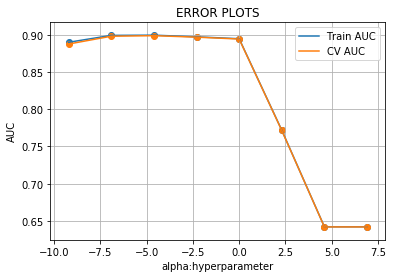

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3)
model.fit(X_train_avgw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc= model.cv_results_['mean_train_score'][1:17:2]
cv_auc = model.cv_results_['mean_test_score'] [1:17:2]
plt.plot(np.log(Alpha), train_auc, label='Train AUC')
plt.plot(np.log(Alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(Alpha), train_auc)
plt.scatter(np.log(Alpha), cv_auc)
plt.legend()
plt.grid(True)
plt.xlabel("alpha:hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

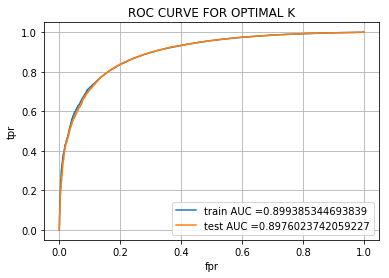

Area under train roc 0.899385344693839
Area under test roc 0.8976023742059227


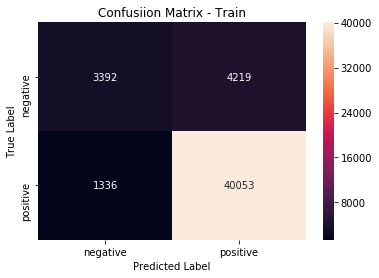

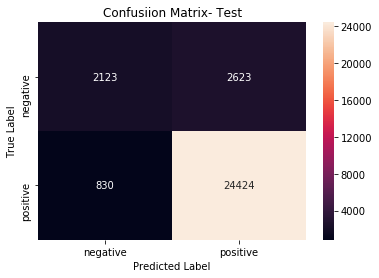

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
optimal_alpha = 0.01
optimal_penalty= 'l2'
svm_opt = SGDClassifier(alpha=optimal_alpha,penalty=optimal_penalty,loss='hinge') 
svm_opt.fit(X_train_avgw2v,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_avgw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_avgw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Linear SVM on TFIDF Word2Vec

In [ ]:
model = TfidfVectorizer()
model.fit(X_tr.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancetrain): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
#######################################################################################
model = TfidfVectorizer()
model.fit(X_tr.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_cv_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancecv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_vectors.append(sent_vec)
    row += 1
#####################################################################################################################
model = TfidfVectorizer()
model.fit(X_tr.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancetest): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [20:43<00:00, 24.13it/s]


In [ ]:
X_train_tfw2v = tfidf_train_vectors
X_cv_tfw2v = tfidf_cv_vectors
X_test_tfw2v = tfidf_test_vectors

Model with best parameters :
 {'alpha': 1, 'penalty': 'l2'}


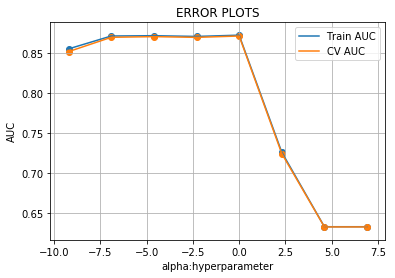

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3)
model.fit(X_train_tfw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc= model.cv_results_['mean_train_score'][1:17:2]
cv_auc = model.cv_results_['mean_test_score'] [1:17:2]
plt.plot(np.log(Alpha), train_auc, label='Train AUC')
plt.plot(np.log(Alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(Alpha), train_auc)
plt.scatter(np.log(Alpha), cv_auc)
plt.legend()
plt.grid(True)
plt.xlabel("alpha:hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

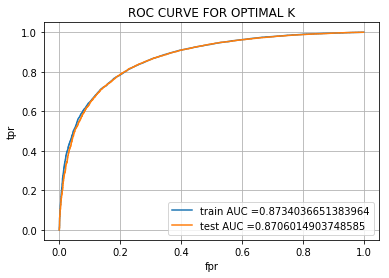

Area under train roc 0.8734036651383964
Area under test roc 0.8706014903748585


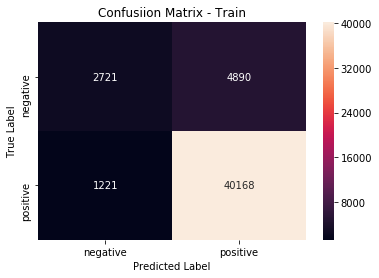

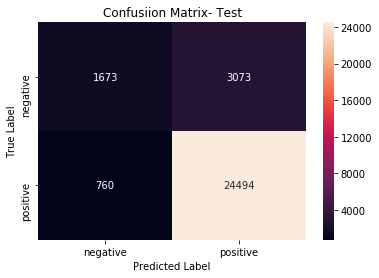

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
optimal_alpha = 0.01
optimal_penalty= 'l2'
svm_opt = SGDClassifier(alpha=optimal_alpha,penalty=optimal_penalty,loss='hinge') 
svm_opt.fit(X_train_tfw2v,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_tfw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_tfw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_tfw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# SVM Using RBF Kernal

For RBF kernal as it is computationaly expensive we will take 20k points

In [ ]:
#sampling 100k points 
final_20k = final.sample(20000)
#sorting 100kpoints based on time
final_20k['Time'] = pd.to_datetime(final_20k['Time'],unit='s')
final_20k = final_20k.sort_values('Time')
#reseting index
final_20k = final_20k.reset_index(drop=True)

In [ ]:
final_20k['Score'].value_counts()

1    16888
0     3112
Name: Score, dtype: int64

In [ ]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = final_20k['clean_text']
y = final_20k['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3)

## SVM with RBF on BOW

In [ ]:
#applying bow on x_train and x_test
vectorizer = CountVectorizer(min_df=10,max_features=500)
vectorizer.fit(X_tr)
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_tr)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

In [ ]:
print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_cv_bow is {}'.format(X_cv_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (9800, 500)
shape of X_cv_bow is (4200, 500)
shape of X_test_bow is (6000, 500)


Model with best parameters :
 {'C': 1, 'gamma': 0.01}


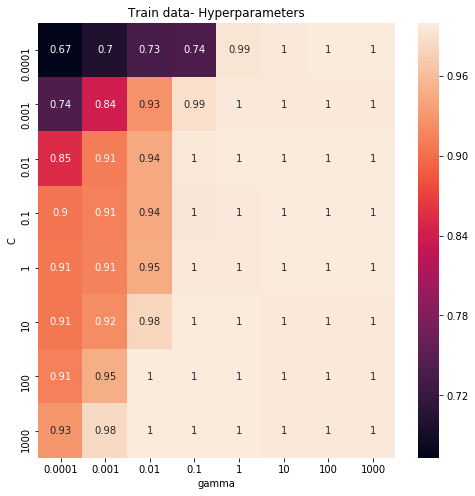

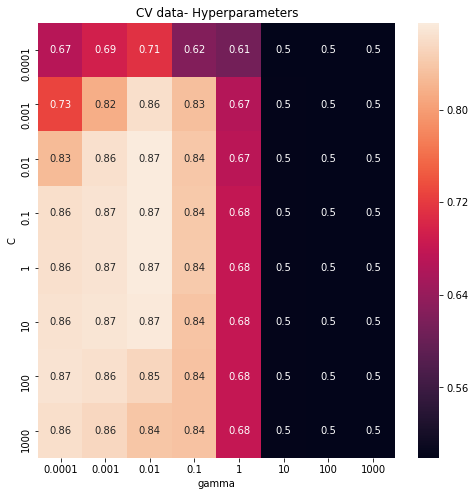

In [ ]:
from sklearn.svm import SVC
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3)
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc= model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
fig = plt.figure(figsize=(8,8))
sns.heatmap(train_auc,xticklabels=Gamma,yticklabels=c,annot=True)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(8,8))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=Gamma,yticklabels=c,annot=True)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()


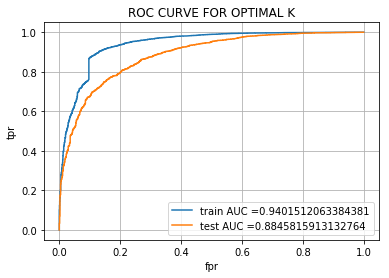

Area under train roc 0.9401512063384381
Area under test roc 0.8845815913132764


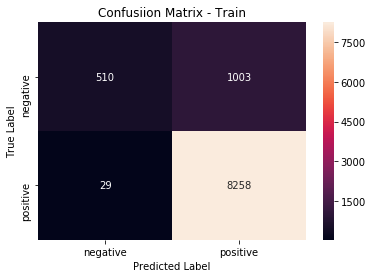

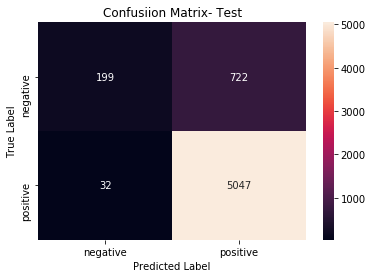

In [ ]:
optimal_C = 1
optimal_gamma = 0.01
best_est = SVC(C=optimal_C,gamma=optimal_gamma,probability=True)
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_bow))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_bow))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## SVM With RBF on TFIDF

In [ ]:
#applying tfidf on x_train and x_test
vectorizer = TfidfVectorizer(min_df=10,max_features=500)
vectorizer.fit(X_tr)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_tr)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

Model with best parameters :
 {'C': 10, 'gamma': 1}


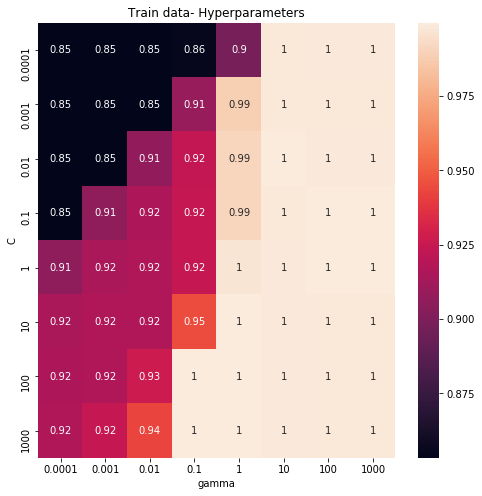

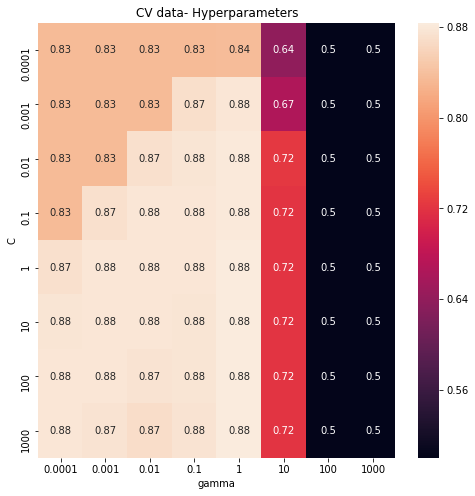

In [ ]:
from sklearn.svm import SVC
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3)
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc= model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
fig = plt.figure(figsize=(8,8))
sns.heatmap(train_auc,xticklabels=Gamma,yticklabels=c,annot=True)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(8,8))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=Gamma,yticklabels=c,annot=True)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()


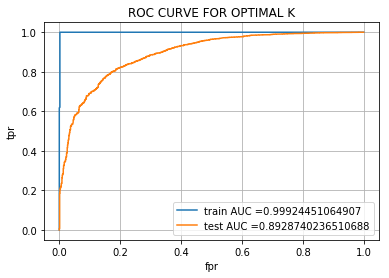

Area under train roc 0.99924451064907
Area under test roc 0.8928740236510688


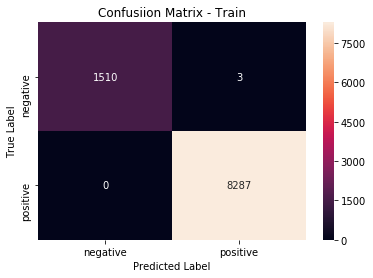

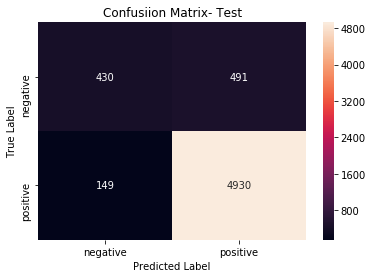

In [ ]:
optimal_C = 10
optimal_gamma = 1
best_est = SVC(C=optimal_C,gamma=optimal_gamma,probability=True)
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_tfidf))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_tfidf))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## SVM with RBF on AVG-W2V

In [ ]:
# Train your own Word2Vec model using your own text corpus
preprocessed_reviews = X_tr.values
train_sentance=[]
for sentance in preprocessed_reviews:
    train_sentance.append(sentance.split())

want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(train_sentance,min_count=5,size=50, workers=4)
w2v_words_train = list(w2v_model_train.wv.vocab)
#################################################################################
# compute average word2vec for each review for train data.
preprocessed_reviews = X_tr.values
list_of_sentancetrain = []
for sentance in preprocessed_reviews:
    list_of_sentancetrain.append(sentance.split())


sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetrain): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

###########################################################
# compute average word2vec for each review for cv data.
preprocessed_reviews = X_cv.values
list_of_sentancecv = []
for sentance in preprocessed_reviews:
    list_of_sentancecv.append(sentance.split())

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancecv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

#################################################################

# compute average word2vec for each review for test data.
preprocessed_reviews = X_test.values
list_of_sentancetest = []
for sentance in preprocessed_reviews:
    list_of_sentancetest.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 9800/9800 [00:28<00:00, 339.24it/s]


9800
50


100%|██████████| 4200/4200 [00:12<00:00, 337.03it/s]


4200
50


100%|██████████| 6000/6000 [00:17<00:00, 337.99it/s]


6000
50


In [ ]:
X_train_avgw2v = sent_vectors_train
X_cv_avgw2v = sent_vectors_cv
X_test_avgw2v = sent_vectors_test

Model with best parameters :
 {'C': 1000, 'gamma': 0.01}


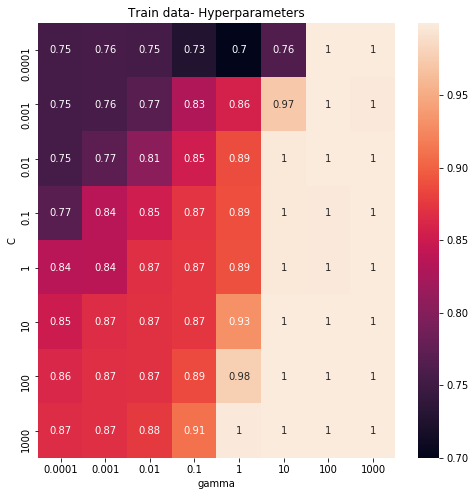

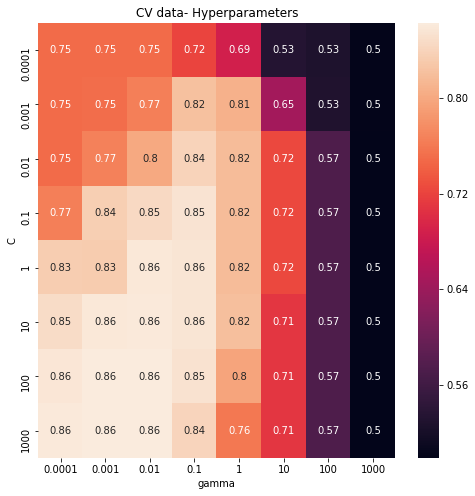

In [ ]:
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3)
model.fit(X_train_avgw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc= model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
fig = plt.figure(figsize=(8,8))
sns.heatmap(train_auc,xticklabels=Gamma,yticklabels=c,annot=True)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(8,8))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=Gamma,yticklabels=c,annot=True)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

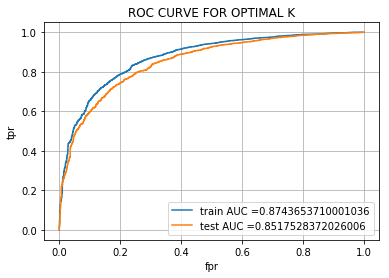

Area under train roc 0.8743653710001036
Area under test roc 0.8517528372026006


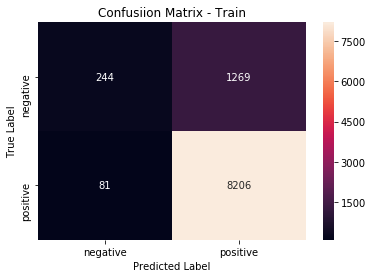

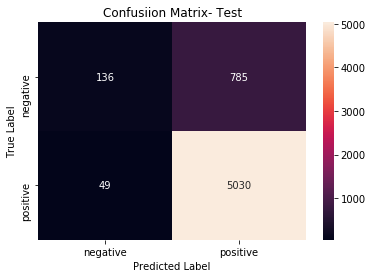

In [ ]:
optimal_C = 1000
optimal_gamma = 0.01
best_est = SVC(C=optimal_C,gamma=optimal_gamma,probability=True)
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_avgw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_avgw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## SVM With RBF On TFIDF-W2V

In [ ]:
model = TfidfVectorizer()
model.fit(X_tr.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancetrain): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
#######################################################################################
model = TfidfVectorizer()
model.fit(X_tr.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_cv_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancecv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_cv_vectors.append(sent_vec)
    row += 1
#####################################################################################################################
model = TfidfVectorizer()
model.fit(X_tr.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentancetest): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
#######################################################################################
X_train_tfw2v = tfidf_train_vectors
X_cv_tfw2v = tfidf_cv_vectors
X_test_tfw2v = tfidf_test_vectors

100%|██████████| 6000/6000 [02:01<00:00, 49.52it/s]


Model with best parameters :
 {'C': 1000, 'gamma': 0.0001}


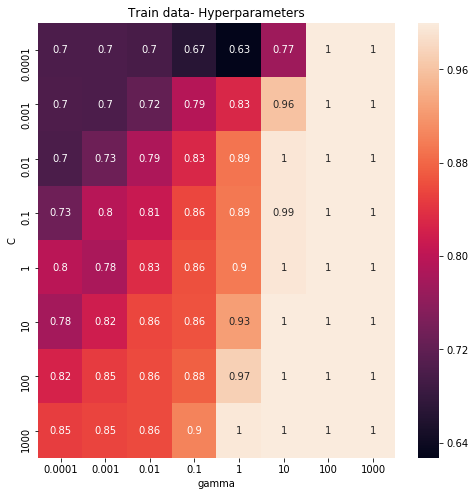

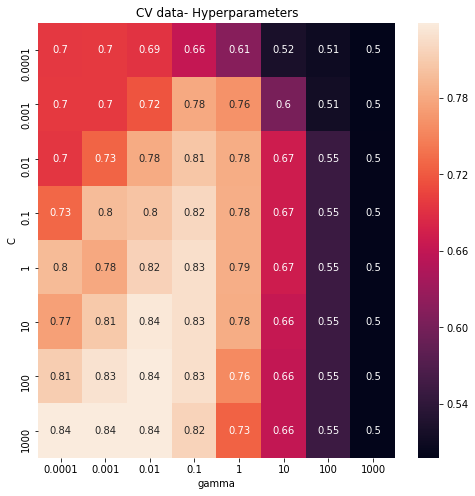

In [ ]:
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3)
model.fit(X_train_tfw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc= model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
fig = plt.figure(figsize=(8,8))
sns.heatmap(train_auc,xticklabels=Gamma,yticklabels=c,annot=True)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Train data- Hyperparameters')
plt.show()

fig2 = plt.figure(figsize=(8,8))
plt.title('CV data- Hyperparameters')
sns.heatmap(cv_auc,xticklabels=Gamma,yticklabels=c,annot=True)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

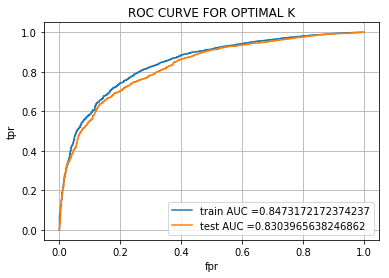

Area under train roc 0.8473172172374237
Area under test roc 0.8303965638246862


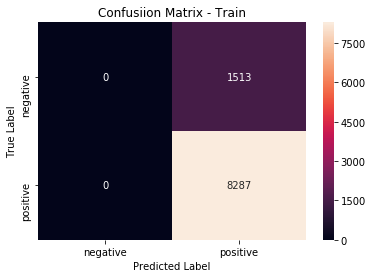

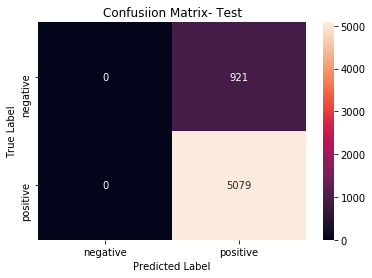

In [ ]:
optimal_C = 1000
optimal_gamma = 0.0001
best_est = SVC(C=optimal_C,gamma=optimal_gamma,probability=True)
best_est = best_est.fit(X_train_tfw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
############################################

#confusion matrix for train data
cm = confusion_matrix(y_tr,best_est.predict(X_train_tfw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix - Train")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#############################################
#confusion matrix for test data
cm = confusion_matrix(y_test,best_est.predict(X_test_tfw2v))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix- Test")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Conclusion

In [ ]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","kernel","penalty","Hyperparam-alpha","Hyperparam-C","gamma","Train AUC", "Test AUC"]

z.add_row(["bow","SVM","linear","l2",0.001,"-","-",0.967463341255992, 0.9359869173779316])
z.add_row(["tfidf","SVM","linear","l2",0.0001,"-","-",0.9667256495591707, 0.9441476453426193])
z.add_row(["avg-w2v","SVM","linear","l2",0.01,"-","-",0.899385344693839, 0.8976023742059227])
z.add_row(["tfidf-w2v","SVM","linear","l2",1,"-","-",0.8734036651383964,0.8706014903748585])
z.add_row(["bow","SVM","RBF","-","-",1,0.01,0.9401512063384381,0.8845815913132764])
z.add_row(["tfidf","SVM","RBF","-","-",10,1,0.99924451064907,0.8928740236510688])
z.add_row(["avg-w2v","SVM","RBF","-","-",1000,0.01,0.8743653710001036,0.8517528372026006])
z.add_row(["tfidf-w2v","SVM","RBF","-","-",1000,0.0001,0.8473172172374237,0.8303965638246862])
print(z)


+-----------+-----------+--------+---------+------------------+--------------+--------+--------------------+--------------------+
|   Vector  | Algorithm | kernel | penalty | Hyperparam-alpha | Hyperparam-C | gamma  |     Train AUC      |      Test AUC      |
+-----------+-----------+--------+---------+------------------+--------------+--------+--------------------+--------------------+
|    bow    |    SVM    | linear |    l2   |      0.001       |      -       |   -    | 0.967463341255992  | 0.9359869173779316 |
|   tfidf   |    SVM    | linear |    l2   |      0.0001      |      -       |   -    | 0.9667256495591707 | 0.9441476453426193 |
|  avg-w2v  |    SVM    | linear |    l2   |       0.01       |      -       |   -    | 0.899385344693839  | 0.8976023742059227 |
| tfidf-w2v |    SVM    | linear |    l2   |        1         |      -       |   -    | 0.8734036651383964 | 0.8706014903748585 |
|    bow    |    SVM    |  RBF   |    -    |        -         |      1       |  0.01  | 0.